### Inputs:
- `input_file`: Path to the input file containing CDR data.

### Outputs:
- `CDR_over_all_plot_dic`: Dictionary to store CDR data for each chromosome. Each region is stored in a format of `[chromosome name, region start, region end, region status]`.
  - Example: 
    ```python
    {
        'chr1_PATERNAL': [['chr1', 1000, 2000, 'CDR'], ['chr1', 3000, 4000, 'CDR_Transition']],
        'chr1_MATERNAL': [['chr1', 5000, 6000, 'CDR']]
    }
    ```
- `CDR_dict`: Dictionary to store CDR region start and end for each chromosome. Each region is stored in a format of `chromosome name: [[start, end]]`.
  - Example: 
    ```python
    {
        'chr1': [[1000, 2000], [5000, 6000]]
    }
    ```
- `CDR_transition_dict`: Dictionary to store CDR transition regions. Each region is stored in a format of `chromosome name: [[start, end]]`.
  - Example: 
    ```python
    {
        'chr1': [[3000, 4000]]
    }
    ```

### Description:
This cell initializes dictionaries to store CDR data and reads the input file to populate these dictionaries. It processes each line of the input file to extract chromosome number, CDR start and end positions, and CDR status, and stores this information in the appropriate dictionaries.


In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import itertools
from tabulate import tabulate
import csv
import random
import matplotlib.colors as mcolors


import os

input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_over_all_plot_dic = {}

for num in range (1,23):
        CDR_over_all_plot_dic[f'chr{num}_PATERNAL'] = []
        CDR_over_all_plot_dic[f'chr{num}_MATERNAL'] = []
CDR_over_all_plot_dic['chrX_MATERNAL'] = []
#CDR_over_all_plot_dic['chrY_PATERNAL'] = []
CDR_dict = {}
CDR_transition_dict = {} 

with open(input_file, 'r') as infile:  
    for i in infile:
        CDR_over_all_plot_dic
        chr_num = i.split('\t')[0]
        CDR_start = int(i.split('\t')[1])
        CDR_end = int(i.split('\t')[2].split('\n')[0])
        CDR_status = i.split('\t')[3]
        CDR_over_all_plot_dic[chr_num] .append ([chr_num,CDR_start,CDR_end,CDR_status])
        if CDR_status == 'CDR': 
            if chr_num not in CDR_dict:
                    CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
            elif chr_num in CDR_dict:  
                    CDR_dict[chr_num].append ([CDR_start ,CDR_end])
        elif CDR_status == 'CDR_Transition': 
            if chr_num not in CDR_transition_dict:
                    CDR_transition_dict[chr_num] = [[CDR_start ,CDR_end]]
            elif chr_num in CDR_dict:  
                    CDR_transition_dict[chr_num].append ([CDR_start ,CDR_end])




### Inputs:
- `CDR_dict`: Dictionary containing CDR regions.

### Outputs:
- `varibility_data_frame`: DataFrame to store variability data for each chromosome.
  - Example:
    ```python
    hap CDR variability  CDR num difference
    chr1                NaN                NaN
    chr2                NaN                NaN
    ...
    ```
- `chromosome_CDR`: DataFrame to store total CDR length and number for each chromosome.
  - Example:
    ```python
    total CDR length  CDR num
    chr1_PATERNAL              10000        5
    chr1_MATERNAL              8000         4
    ...
    ```
- `maternal_avg`: Average total CDR length for maternal chromosomes.
  - Example:
    ```python
    8000
    ```
- `paternal_avg`: Average total CDR length for paternal chromosomes.
  - Example:
    ```python
    10000
    ```
- `overall_avg`: Overall average total CDR length.
  - Example:
    ```python
    9000
    ```

### Description:
This cell creates DataFrames to store variability data and CDR data for each chromosome. It calculates the total CDR length and number for each chromosome and stores this information in the `chromosome_CDR` DataFrame. It also calculates the average total CDR length for maternal, paternal, and overall chromosomes.

In [2]:
chromosomes = [f'chr{i}' for i in range(1, 23)]
varibility_columns = ['hap CDR variability', 'CDR num difference']
varibility_data_frame = pd.DataFrame(index=chromosomes, columns = varibility_columns )

chromosomes_PAT = [ f'chr{i}_PATERNAL' for i in range(1, 23)]
chromosomes_MAT = [ f'chr{i}_MATERNAL' for i in range(1, 23)]
chromosomes_MAT_PAT = chromosomes_PAT + chromosomes_MAT

CDR_columns = ['total CDR length', 'CDR num']
chromosome_CDR = pd.DataFrame(index=chromosomes_MAT_PAT, columns = CDR_columns  )


for chromosome in CDR_dict:
    CDRs = CDR_dict[chromosome]
    total_CDR_length = 0
    total_CDR_num = 0
    for CDR in CDRs: 
        CDR_start = CDR[0]
        CDR_end = CDR[1]
        total_CDR_length += CDR_end - CDR_start
        total_CDR_num += 1 
    chromosome_CDR.at[chromosome, 'total CDR length'] = total_CDR_length
    chromosome_CDR.at[chromosome, 'CDR num'] = total_CDR_num
chromosome_CDR = chromosome_CDR.sort_index()
maternal_avg = chromosome_CDR[chromosome_CDR.index.str.endswith('_MATERNAL')]['total CDR length'].mean()
paternal_avg = chromosome_CDR[chromosome_CDR.index.str.endswith('_PATERNAL')]['total CDR length'].mean()
overall_avg = chromosome_CDR['total CDR length'].mean()


# Initialize an empty list to hold the data
data = []

# Iterate through the CDR_dict and calculate the difference for each region
for chromosome, regions in CDR_dict.items():
    for region in regions:
        start, end = region
        difference = end - start
        data.append({'Chromosome': chromosome, 'Difference': difference})

# Convert the list to a DataFrame
cdr_regions_df = pd.DataFrame(data)



In [3]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD.bam'
CENPC_AS_bam_file = '/private/groups/migalab/dan/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/20240109_1200_6B_PAS52674_0adbae11/pod5_pass/explicit/01_09_24_R1041_DiMeLoAdaptive_CENPC_5mC_6mA_winnowmap_sorted_modkit.bam'
H3K9me3_AS_bam_file = '/private/groups/migalab/dan/08_05_24_R1041_ULadapt_Dimelo_H3K9ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_1/20240805_1148_1F_PAU87705_0451cc00/pod5/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_mA_mC_winnowmap_sorted_MD.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')



np.set_printoptions(threshold=np.inf)
min_quality_score = 8

#Load the bam file 
CENPA_bamfile = pysam.AlignmentFile( "/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD.bam",
    "rb") 

H3K9_bamfile = pysam.AlignmentFile(
    "/private/groups/migalab/dan/08_05_24_R1041_ULadapt_Dimelo_H3K9ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_1/20240805_1148_1F_PAU87705_0451cc00/pod5/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_mA_mC_winnowmap_sorted_MD.bam",
    "rb") 




In [4]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '-' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))


    
    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]



    target_start_dash = indexes.index (target_start_no_dash)

        
    try:
        target_end_dash = indexes.index (target_end_no_dash)
    except ValueError: 
        target_end_dash = indexes[-1]




    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset





In [5]:

def region_read_mA_density_calculator (chr_name,region_start_index,region_end_index,bamfile,mod_tag,filtering_val): 
    data_table = [] 
    region_density = []
    region_base = 0 
            


    for read in bamfile.fetch(chr_name,region_start_index,region_end_index):

        #make an if statement to check a specific read front, middle, end regions 
        #setting read start, end, density, length variables 
            
        #Get the starting and ending positions of the reads 
        read_start_position = read.reference_start
        read_end_position = read.reference_end
        read_density = 0 

        #Get sequence information which shows deletions and insertions 
        sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)


        #make a numpy of the sequence length which eliminates the deletion
        
        read_sequence_insertion_included = ''
        genomic_alignment_sequence_deletion_mistach_included = ''
        
        for item in sequence:
            if item[0] is None:
                read_sequence_insertion_included+='-'
            elif item[1] is None:
                genomic_alignment_sequence_deletion_mistach_included += '-'
            else: 
                read_sequence_insertion_included+=item[2]
                genomic_alignment_sequence_deletion_mistach_included +=item[2]

        
        read_sequence_insertion_included = read_sequence_insertion_included.upper()
        genomic_alignment_sequence_deletion_mistach_included = genomic_alignment_sequence_deletion_mistach_included.upper()


        genomic_alignment_sequence_deletion_mistach_included_mask = np.array(
            [char != '-' for char in genomic_alignment_sequence_deletion_mistach_included])

        #take sequence length excluding insertions 
        insertions = read_sequence_insertion_included.count ("-")
        no_insertion_no_deletion_sequence_length = len(read_sequence_insertion_included) 
        
        
        mod=read.modified_bases_forward
        
        #make a mod score with its original length 
        mod_score = np.zeros(len(genomic_alignment_sequence_deletion_mistach_included),)

        
        #make transfer mA positions to mod np array corresponded to their sequence positions 
        try:
            if mod_tag == 'A':
                for indices, values in mod[('A', 0, 'a')]:
                    mod_score[indices] = values
                mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                


            elif mod_tag == 'CG':
                for indices, values in mod[('C', 0, 'm')]:
                    mod_score[indices] = values
                mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
            
            if read.is_reverse:
                    mod_score = mod_score[::-1]
            


        # No mod would return KeyError 
        except KeyError:
            continue
        mod_score = np.where(mod_score < filtering_val, 0, mod_score)
        # if the regions are longer than the reads 
        if (region_end_index - region_start_index) > (read_end_position - read_start_position):
            # scenario 4: if the reads are inside the region
            if (region_end_index >= read_end_position) and (region_start_index <= read_start_position): 
                mod_start = 0
                mod_end = len(read_sequence_insertion_included)
            
            # scenario 5: if the reads cover the later part of the region
            elif (region_end_index < read_end_position) and (region_start_index > read_start_position): 
                mod_start = 0
                mod_end = no_insertion_no_deletion_sequence_length - read_end_position - region_end_index

            # scenario 6: if the reads cover the starting part of the region 
            elif (region_end_index > read_end_position) and (region_start_index > read_start_position): 
                mod_start = region_start_index - read_start_position 
                mod_end = no_insertion_no_deletion_sequence_length

                
        
        # if the reads are longer than the region selected 
        elif (region_end_index - region_start_index) <= (read_end_position - read_start_position):
            # scenario 1: when the defined region is inside the read
            if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                mod_start = region_start_index - read_start_position 
                mod_end = region_end_index - read_start_position

            # scenario 3: when the defined region covers a bit of the end of the read
            elif (read_end_position < region_end_index) and (read_end_position > region_start_index):
                mod_start = region_start_index - read_start_position

                mod_end = no_insertion_no_deletion_sequence_length

            # scenario 2: when the defined region covers a bit of the beginning of the read
            elif (read_start_position > region_start_index) and (read_start_position < region_end_index):
                mod_start = 0
                mod_end = region_end_index - read_start_position 


        #use the defined starting and ending positons in the region to subset mod numpy
        if (region_start_index - read_start_position) > (no_insertion_no_deletion_sequence_length - insertions):
            continue
        try:
            trimmed_mod_score = mod_subset_producing_step (mod_score,read_sequence_insertion_included,mod_start,mod_end)
        except ValueError:
            continue
        
    
        region_base += (mod_end - mod_start)
        #removing all the zeros 
        mod_no_zeros = trimmed_mod_score[trimmed_mod_score != 0]
        m_mod_tag = len (mod_no_zeros)
        

        #Getting the total amount of As in the subsetted region of the sequence 
        total_mod_tag = read_sequence_insertion_included[mod_start:mod_end].count(mod_tag)
        
        
        #calculate read density
        try:
            read_density = m_mod_tag / total_mod_tag
            
        except ZeroDivisionError:
            pass
        region_density.append (read_density)

        
                
            
        #calculate averaged region density average 
    try:
        region_density_average = sum(region_density)/len(region_density)
    
    except ZeroDivisionError:
        region_density_average = 0
    return region_density_average



In [6]:

def match_cdr_regions(CDR_dict, cdr_regions_df, bamfile):
    """
    Matches CDR regions by size and chromosome from two different datasets 
    and calculates mA and mC densities for the matched regions.

    Args:
        CDR_dict (dict): Dictionary containing chromosomes as keys and lists of CDR start-end tuples as values.
        cdr_regions_df (pd.DataFrame): DataFrame containing the chromosome and region size information.
        bamfile (str): Path to the BAM file used for density calculations.

    Returns:
        pd.DataFrame: DataFrame containing matched CDR regions with calculated mA and mC densities.
    """
    # Step 1: Define columns for the DataFrame
    CDR_columns_individual = ['line number', 'chromosome', 'CDR_start', 'CDR_end']

    # Step 2: Initialize variables
    rows = []
    n = 0

    # Step 3: Populate the chromosome_individual_CDR DataFrame
    for chromosome, CDRs in CDR_dict.items():
        for CDR in CDRs:
            n += 1
            CDR_start, CDR_end = CDR
            rows.append({
                'line number': n,
                'chromosome': chromosome,
                'CDR_start': CDR_start,
                'CDR_end': CDR_end
            })

    # Convert rows to DataFrame
    chromosome_individual_CDR = pd.DataFrame(rows, columns=CDR_columns_individual)

    # Step 4: Calculate the CDR size
    chromosome_individual_CDR['Size'] = chromosome_individual_CDR['CDR_end'] - chromosome_individual_CDR['CDR_start']

    # Step 5: Match CDRs by size and chromosome
    matched_data = []

    for index, region_row in cdr_regions_df.iterrows():
        chromosome = region_row['Chromosome']
        region_size = region_row['Difference']

        match = chromosome_individual_CDR[
            (chromosome_individual_CDR['chromosome'] == chromosome) & 
            (chromosome_individual_CDR['Size'] == region_size)
        ]

        if not match.empty:
            matched_data.append({
                'Chromosome': chromosome,
                'Region Length': region_size,
                'CDR_start': match['CDR_start'].values[0],
                'CDR_end': match['CDR_end'].values[0],
                'mA density': region_read_mA_density_calculator(chromosome, match['CDR_start'].values[0], match['CDR_end'].values[0], bamfile, "A", 240),
                'mC density': region_read_mA_density_calculator(chromosome, match['CDR_start'].values[0], match['CDR_end'].values[0], bamfile, "CG", 230),
            })

    # Step 6: Convert matched data to a DataFrame
    matched_cdr_df = pd.DataFrame(matched_data)

    return matched_cdr_df



In [7]:
CENPA_match_cdr_regions = match_cdr_regions(CDR_dict, cdr_regions_df, CENPA_bamfile)
H3K9_match_cdr_regions = match_cdr_regions(CDR_dict, cdr_regions_df, H3K9me3_AS_bam_file)

KeyboardInterrupt: 

         Chromosome  Region Length  CDR_start   CDR_end  mA density  \
0    chr10_MATERNAL           5356   42097255  42102611    0.036695   
1    chr10_MATERNAL          11020   42139864  42150884    0.019160   
2    chr10_MATERNAL          62902   42214295  42277197    0.014000   
3    chr10_PATERNAL           6023   41441384  41447407    0.017942   
4    chr10_PATERNAL           4328   41454240  41458568    0.016720   
..              ...            ...        ...       ...         ...   
247   chrX_MATERNAL          11964   59281201  59293165    0.022517   
248   chrX_MATERNAL          10900   59358368  59369268    0.023320   
249   chrX_MATERNAL          24604   59422135  59446739    0.016381   
250   chrX_MATERNAL          11664   59465035  59476699    0.020369   
251   chrX_MATERNAL          21057   59483830  59504887    0.018613   

     mC density  
0      0.316110  
1      0.224536  
2      0.136038  
3      0.203779  
4      0.155949  
..          ...  
247    0.140608  
248

### Inputs:
- `cdr_regions_df`: DataFrame containing CDR regions with chromosome and difference (length).
- `chromosome_CDR`: DataFrame containing total CDR length and number for each chromosome.
- `maternal_avg`: Average total CDR length for maternal chromosomes.
- `paternal_avg`: Average total CDR length for paternal chromosomes.
- `overall_avg`: Overall average total CDR length.

### Outputs:
- A plot showing total CDR lengths in chromosomes for young passage.

### Description:
This cell creates a plot to visualize the total CDR lengths in chromosomes for young passage. It iterates through each chromosome and plots the regions, with different colors for maternal and paternal data. It also adds horizontal lines for the average CDR lengths.

In [1]:

def fill_cdr_gaps(matched_cdr_df_sorted):
    """
    Identifies gaps between consecutive CDR regions within each chromosome 
    and fills those gaps with new rows in the DataFrame.
    
    Parameters:
        matched_cdr_df_sorted (pd.DataFrame): A sorted DataFrame containing CDR regions.
        
    Returns:
        pd.DataFrame: A DataFrame with gaps filled between CDR regions.
    """
    gap_rows = []

    for chromosome, group in matched_cdr_df_sorted.groupby('Chromosome'):
        group_sorted = group.sort_values('CDR_start').reset_index(drop=True)
        for i in range(1, len(group_sorted)):
            prev_cdr_end = group_sorted.at[i-1, 'CDR_end']
            current_cdr_start = group_sorted.at[i, 'CDR_start']
            gap_length = current_cdr_start - prev_cdr_end
            if gap_length > 0:
                gap_row = {
                    'Chromosome': chromosome,
                    'Region Length': gap_length,
                    'CDR_start': prev_cdr_end,
                    'CDR_end': current_cdr_start,
                    'mA density': 0.0,
                    'mC density': 100.0
                }
                gap_rows.append(gap_row)

    gaps_df = pd.DataFrame(gap_rows, columns=matched_cdr_df_sorted.columns)
    matched_cdr_df_with_gaps = pd.concat([matched_cdr_df_sorted, gaps_df], ignore_index=True)
    matched_cdr_df_with_gaps = matched_cdr_df_with_gaps.sort_values(['Chromosome', 'CDR_start']).reset_index(drop=True)

    return matched_cdr_df_with_gaps

CENPA_matched_cdr_df_with_gaps = fill_cdr_gaps(CENPA_match_cdr_regions)
H3K9_matched_cdr_df_with_gaps = fill_cdr_gaps(H3K9_match_cdr_regions)




NameError: name 'matched_cdr_df' is not defined

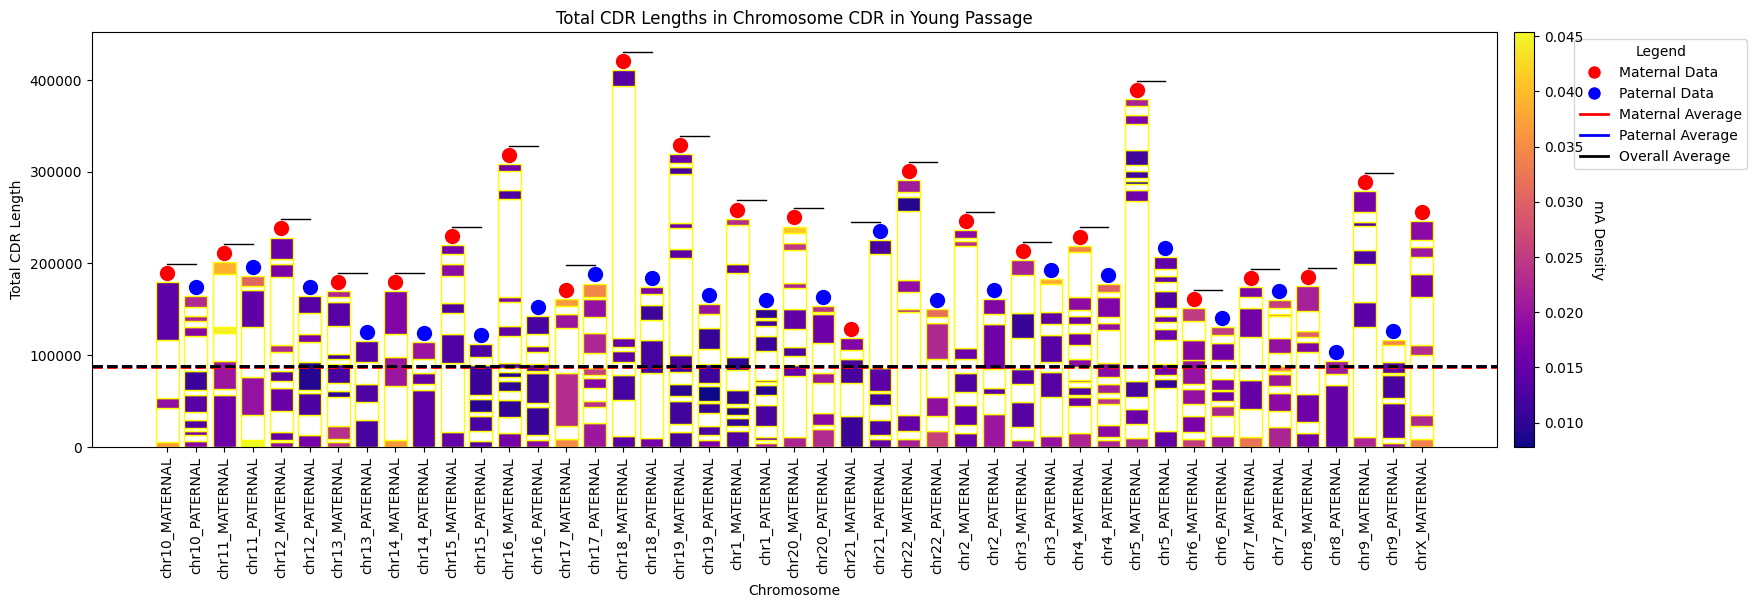

In [20]:


def plot_cdr_lengths_with_density(H3K9_matched_cdr_df_with_gaps):
    """
    Plots total CDR lengths in chromosomes with mA density mapping and highlights maternal and paternal data.

    Parameters:
        H3K9_matched_cdr_df_with_gaps (pd.DataFrame): DataFrame containing CDR regions and mA densities.
    """
    # Use a colormap for better color differentiation
    colormap = plt.cm.plasma  # You can choose a different colormap like 'viridis', 'inferno', 'coolwarm', etc.

    # Calculate min and max mA density, excluding zeros
    non_zero_densities = H3K9_matched_cdr_df_with_gaps[H3K9_matched_cdr_df_with_gaps['mA density'] > 0]['mA density']
    min_density = non_zero_densities.min()
    max_density = non_zero_densities.max()

    # Create the figure and adjust the size
    plt.figure(figsize=(18, 15))

    # Plot the bars for each chromosome
    dot_positions = {}
    for chromosome in H3K9_matched_cdr_df_with_gaps['Chromosome'].unique():
        regions = H3K9_matched_cdr_df_with_gaps[H3K9_matched_cdr_df_with_gaps['Chromosome'] == chromosome]
        total_height = 0
        for _, region in regions.iterrows():
            length = region['Region Length']
            density = region['mA density']
            
            # Map the density to a color
            color = colormap((density - min_density) / (max_density - min_density)) if density > 0 else 'white'
            
            # Plot the bar
            plt.bar(chromosome, length, bottom=total_height, color=color, edgecolor='yellow')
            total_height += length

        # Determine dot color for maternal/paternal
        dot_color = 'red' if '_MATERNAL' in chromosome else 'blue'
        dot_position = total_height + 10000  # Adjust this value if needed
        plt.plot(chromosome, dot_position, marker='o', color=dot_color, markersize=10)

        # Store dot positions for connecting lines
        base_chromosome = chromosome.replace('_MATERNAL', '').replace('_PATERNAL', '')
        if base_chromosome not in dot_positions:
            dot_positions[base_chromosome] = []
        dot_positions[base_chromosome].append((chromosome, dot_position))

    # Draw lines connecting maternal and paternal dots
    for base_chromosome, positions in dot_positions.items():
        if len(positions) == 2:
            chrom_1, pos_1 = positions[0]
            chrom_2, pos_2 = positions[1]
            line_y = max(pos_1, pos_2) + 5000
            plt.plot([chrom_1, chrom_2], [line_y, line_y], color='black', linestyle='-', linewidth=1)

    # Add a color bar
    norm = mcolors.Normalize(vmin=min_density, vmax=max_density)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('mA Density', rotation=270, labelpad=15)

    # Add titles and labels
    plt.title('Total CDR Lengths in Chromosome CDR')
    plt.xlabel('Chromosome')
    plt.ylabel('Total CDR Length')
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_cdr_lengths_with_density(H3K9_matched_cdr_df_with_gaps)
plot_cdr_lengths_with_density(CENPA_matched_cdr_df_with_gaps)

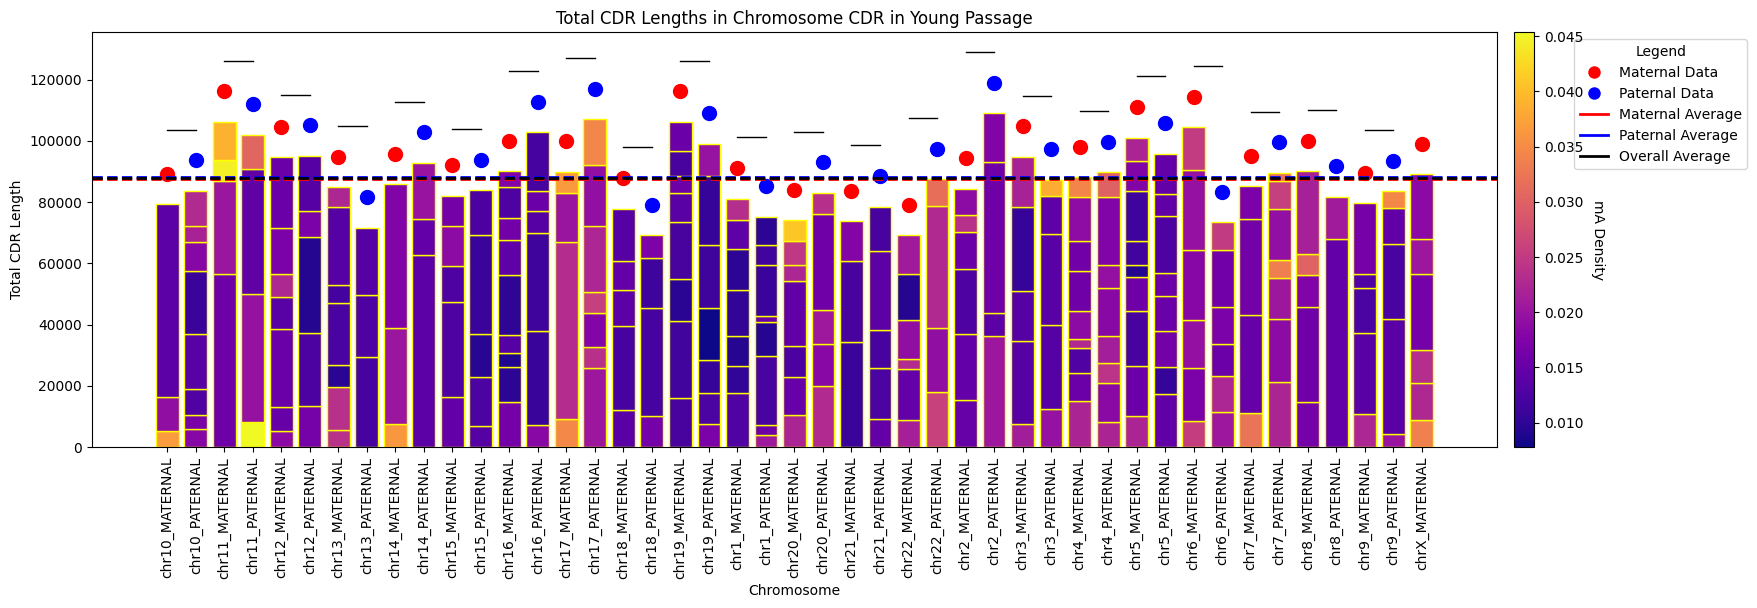

In [18]:

def plot_cdr_lengths_with_density_no_gap(H3K9_matched_cdr_df_with_gaps):
    """
    Plots total CDR lengths in chromosomes with mA density mapping and highlights maternal and paternal data.

    Parameters:
        H3K9_matched_cdr_df_with_gaps (pd.DataFrame): DataFrame containing CDR regions and mA densities.
    """
    # Use a colormap for better color differentiation
    colormap = plt.cm.plasma  # You can choose a different colormap like 'viridis', 'inferno', 'coolwarm', etc.

    # Calculate min and max mA density from the DataFrame, excluding zeros
    non_zero_densities = H3K9_matched_cdr_df_with_gaps[H3K9_matched_cdr_df_with_gaps['mA density'] > 0]['mA density']
    min_density = non_zero_densities.min()
    max_density = non_zero_densities.max()

    # Create the figure and adjust the size
    plt.figure(figsize=(18, 15))

    # Plot the bars for each chromosome
    dot_positions = {}
    for chromosome in H3K9_matched_cdr_df_with_gaps['Chromosome'].unique():
        regions = H3K9_matched_cdr_df_with_gaps[H3K9_matched_cdr_df_with_gaps['Chromosome'] == chromosome]
        total_height = 0
        for _, region in regions.iterrows():
            length = region['Region Length']
            density = region['mA density']

            # Map the density to a color
            color = colormap((density - min_density) / (max_density - min_density)) if density > 0 else 'white'

            # Plot the bar with the mapped color
            plt.bar(chromosome, length, bottom=total_height, color=color, edgecolor='yellow')
            total_height += length

        # Determine the dot color based on maternal or paternal
        dot_color = 'red' if '_MATERNAL' in chromosome else 'blue'

        # Calculate the position of the dot
        dot_position = total_height + 0.05 * max_density + 10000

        # Plot the dot at the top of the stacked bars
        plt.plot(chromosome, dot_position, marker='o', color=dot_color, markersize=10)

        # Store the position of the dot
        base_chromosome = chromosome.replace('_MATERNAL', '').replace('_PATERNAL', '')
        if base_chromosome not in dot_positions:
            dot_positions[base_chromosome] = []
        dot_positions[base_chromosome].append((chromosome, dot_position))

    # Draw lines connecting maternal and paternal dots
    for base_chromosome, positions in dot_positions.items():
        if len(positions) == 2:
            chrom_1, pos_1 = positions[0]
            chrom_2, pos_2 = positions[1]
            line_y = max(pos_1, pos_2) + 0.02 * max_density + 10000
            plt.plot([chrom_1, chrom_2], [line_y, line_y], color='black', linestyle='-', linewidth=1)

    # Add a color bar to show the density gradient
    norm = mcolors.Normalize(vmin=min_density, vmax=max_density)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('mA Density', rotation=270, labelpad=15)

    # Add titles and labels
    plt.title('Total CDR Lengths in Chromosome CDR')
    plt.xlabel('Chromosome')
    plt.ylabel('Total CDR Length')
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_cdr_lengths_with_density_no_gap(H3K9_matched_cdr_df_with_gaps)
plot_cdr_lengths_with_density_no_gap(CENPA_matched_cdr_df_with_gaps)